<h2 align="center">Color Based Tracker Implementation</h2>

#### Import required libraries and dataset from Kaggle

In [13]:

import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import kagglehub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# download
root_path = kagglehub.dataset_download("moltean/fruits")
data_root = os.path.join(root_path, "fruits-360_100x100", "fruits-360")

transform = transforms.ToTensor()

# full datasets
train_full = datasets.ImageFolder(os.path.join(data_root, "Training"), transform=transform)
test_full  = datasets.ImageFolder(os.path.join(data_root, "Test"),     transform=transform)

# choose 2000 train and 200 test samples
random.seed(0)
train_indices = random.sample(range(len(train_full)), 5000)
test_indices  = random.sample(range(len(test_full)),  1000)

train_ds = Subset(train_full, train_indices)
test_ds  = Subset(test_full,  test_indices)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

print("Train size:", len(train_ds))   # 2000
print("Test size:",  len(test_ds))    # 200


Using Colab cache for faster access to the 'fruits' dataset.
Train size: 5000
Test size: 1000


#### Choose which fruit we want to track by color


In [26]:
# class names from the full training set
class_names = train_full.classes
print("Number of classes:", len(class_names))
print("Example classes:", class_names[:10])

# choose which fruit you want to track by color
TARGET_CLASS_NAME = "Apple Golden 1"

if TARGET_CLASS_NAME not in class_names:
    raise ValueError(f"{TARGET_CLASS_NAME} not found in Fruits 360 classes")

target_idx = class_names.index(TARGET_CLASS_NAME)
print("Target class index:", target_idx, "name:", TARGET_CLASS_NAME)

# how many images of the target class in train and test subsets
target_train = 0
target_test = 0

for images, labels in train_loader:
    for label in labels:
        if label.item() == target_idx:
            target_train += 1

for images, labels in test_loader:
    for label in labels:
        if label.item() == target_idx:
            target_test += 1

print("Target class in train subset:", target_train)
print("Target class in test subset:", target_test)


Number of classes: 228
Example classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']
Target class index: 16 name: Apple Golden 1
Target class in train subset: 18
Target class in test subset: 4


#### helper: tensor -> BGR image for OpenCV

In [27]:
def tensor_to_bgr(tensor_img):
    """
    tensor_img: torch tensor, shape C x H x W, values in [0, 1]
    returns: uint8 BGR image for OpenCV, shape H x W x 3
    """
    img = tensor_img.numpy()              # C x H x W
    img = np.transpose(img, (1, 2, 0))    # H x W x C
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img_bgr

#### Build a simple HSV color range from the target class in the training set


In [28]:
def estimate_hsv_range_for_target_tight(max_images=100, pixels_per_image=400,
                                        low_q=15, high_q=85):
    hsv_samples = []

    used_images = 0
    for images, labels in train_loader:
        for img_tensor, label in zip(images, labels):
            if label.item() != target_idx:
                continue

            img = img_tensor.numpy()
            img = np.transpose(img, (1, 2, 0))
            img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

            h = hsv[:, :, 0].flatten()
            s = hsv[:, :, 1].flatten()
            v = hsv[:, :, 2].flatten()

            num_pix = len(h)
            take = min(pixels_per_image, num_pix)
            idx = np.random.choice(num_pix, size=take, replace=False)

            hsv_samples.append(
                np.stack([h[idx], s[idx], v[idx]], axis=1)
            )

            used_images += 1
            if used_images >= max_images:
                break
        if used_images >= max_images:
            break

    hsv_samples = np.concatenate(hsv_samples, axis=0)

    lower = np.percentile(hsv_samples, low_q, axis=0)
    upper = np.percentile(hsv_samples, high_q, axis=0)

    lower = lower.astype(np.uint8)
    upper = upper.astype(np.uint8)

    # enforce a bit of saturation and value so we ignore gray or very dark pixels
    lower[1] = max(lower[1], 40)
    lower[2] = max(lower[2], 40)

    return lower, upper

lower_hsv, upper_hsv = estimate_hsv_range_for_target_tight()
print("HSV:", lower_hsv)
print("HSV:", upper_hsv)

HSV: [ 18  40 136]
HSV: [ 25 176 255]


#### Function that applies the color based tracker to a single image


In [29]:

def color_track_mask(img_bgr, lower_hsv, upper_hsv):
    """
    Produce a binary mask where pixels in the HSV range are 255, others 0.
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # small clean up
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask


In [30]:
def mask_area_ratio(img_bgr, lower_hsv, upper_hsv):
    mask = color_track_mask(img_bgr, lower_hsv, upper_hsv)
    return np.count_nonzero(mask) / mask.size


#### compute mask area ratios for all training images


In [31]:
pos_ratios = []
neg_ratios = []

for images, labels in train_loader:
    for img_tensor, label in zip(images, labels):
        img_bgr = tensor_to_bgr(img_tensor)
        ratio = mask_area_ratio(img_bgr, lower_hsv, upper_hsv)

        if label.item() == target_idx:
            pos_ratios.append(ratio)
        else:
            neg_ratios.append(ratio)

pos_ratios = np.array(pos_ratios)
neg_ratios = np.array(neg_ratios)

print("Positive ratios count:", len(pos_ratios))
print("Negative ratios count:", len(neg_ratios))
print("Positive ratio mean:", pos_ratios.mean(), "std:", pos_ratios.std())
print("Negative ratio mean:", neg_ratios.mean(), "std:", neg_ratios.std())


Positive ratios count: 18
Negative ratios count: 4982
Positive ratio mean: 0.4696777777777778 std: 0.040124411460627424
Negative ratio mean: 0.031193877960658367 std: 0.07875300105574766


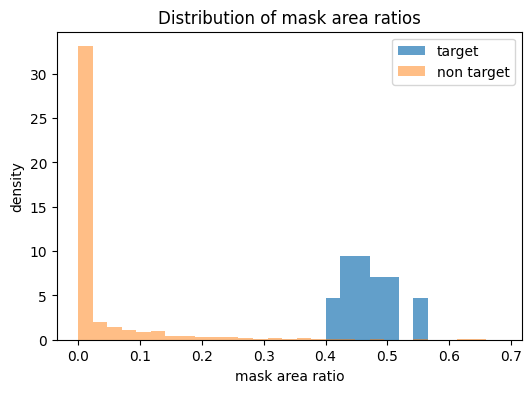

In [32]:
plt.figure(figsize=(6, 4))

# common bin edges for both
max_val = max(pos_ratios.max(), neg_ratios.max())
bins = np.linspace(0, max_val, 30)

plt.hist(pos_ratios, bins=bins, alpha=0.7, label="target", density=True)
plt.hist(neg_ratios, bins=bins, alpha=0.5, label="non target", density=True)

plt.xlabel("mask area ratio")
plt.ylabel("density")
plt.legend()
plt.title("Distribution of mask area ratios")
plt.show()


#### Evaluation Metrices

In [33]:
def evaluate_threshold(thresh, pos_ratios, neg_ratios):
    # predict target if ratio >= thresh
    tp = np.sum(pos_ratios >= thresh)
    fn = np.sum(pos_ratios < thresh)
    fp = np.sum(neg_ratios >= thresh)
    tn = np.sum(neg_ratios < thresh)

    total = tp + tn + fp + fn
    acc = (tp + tn) / total
    prec = tp / max(tp + fp, 1)
    rec = tp / max(tp + fn, 1)
    f1 = 2 * prec * rec / max(prec + rec, 1e-8)
    return acc, prec, rec, f1


candidates = np.linspace(0.0, 0.5, 101)  # ratios between 0 and 0.5

best_f1 = -1.0
best_thresh = None
best_metrics = None

for t in candidates:
    acc, prec, rec, f1 = evaluate_threshold(t, pos_ratios, neg_ratios)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
        best_metrics = (acc, prec, rec, f1)

print("Best threshold on training set:", best_thresh)
print("Training set metrics at best threshold:")
print(f"Accuracy: {best_metrics[0]:.3f}")
print(f"Precision: {best_metrics[1]:.3f}")
print(f"Recall:    {best_metrics[2]:.3f}")
print(f"F1:        {best_metrics[3]:.3f}")


Best threshold on training set: 0.43
Training set metrics at best threshold:
Accuracy: 0.993
Precision: 0.327
Recall:    0.889
F1:        0.478


#### Evaluate on test set using learned threshold


Confusion matrix for color based tracker with learned threshold:
TP: 4 FP: 16 TN: 980 FN: 0
Accuracy:  0.984
Precision: 0.200
Recall:    1.000
F1 score:  0.333


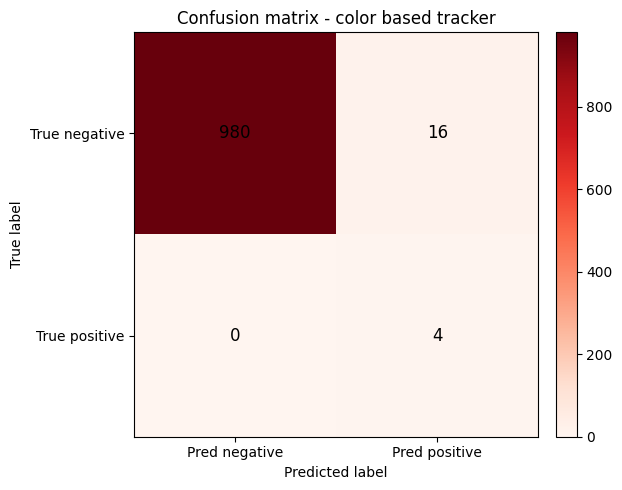

In [34]:

def is_target_image_with_thresh(img_bgr, lower_hsv, upper_hsv, thresh):
    ratio = mask_area_ratio(img_bgr, lower_hsv, upper_hsv)
    return ratio >= thresh, ratio


tp = fp = tn = fn = 0

for images, labels in test_loader:
    for img_tensor, label in zip(images, labels):
        img_bgr = tensor_to_bgr(img_tensor)
        pred_target, ratio = is_target_image_with_thresh(
            img_bgr, lower_hsv, upper_hsv, best_thresh
        )
        true_target = (label.item() == target_idx)

        if pred_target and true_target:
            tp += 1
        elif pred_target and not true_target:
            fp += 1
        elif not pred_target and not true_target:
            tn += 1
        elif not pred_target and true_target:
            fn += 1

print("Confusion matrix for color based tracker with learned threshold:")
print("TP:", tp, "FP:", fp, "TN:", tn, "FN:", fn)

total = tp + fp + tn + fn
accuracy = (tp + tn) / total
precision = tp / max(tp + fp, 1)
recall = tp / max(tp + fn, 1)
f1 = 2 * precision * recall / max(precision + recall, 1e-8)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")

cm = np.array([[tn, fp],
               [fn, tp]])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Reds")

# show values on the cells
for i in range(2):
    for j in range(2):
        ax.text(
            j,
            i,
            str(cm[i, j]),
            ha="center",
            va="center",
            color="black",
            fontsize=12,
        )

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred negative", "Pred positive"])
ax.set_yticklabels(["True negative", "True positive"])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion matrix - color based tracker")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [35]:
def is_target_image_with_thresh(img_bgr, lower_hsv, upper_hsv, thresh):
    ratio = mask_area_ratio(img_bgr, lower_hsv, upper_hsv)
    return (ratio >= thresh), ratio


#### Successful detection examples

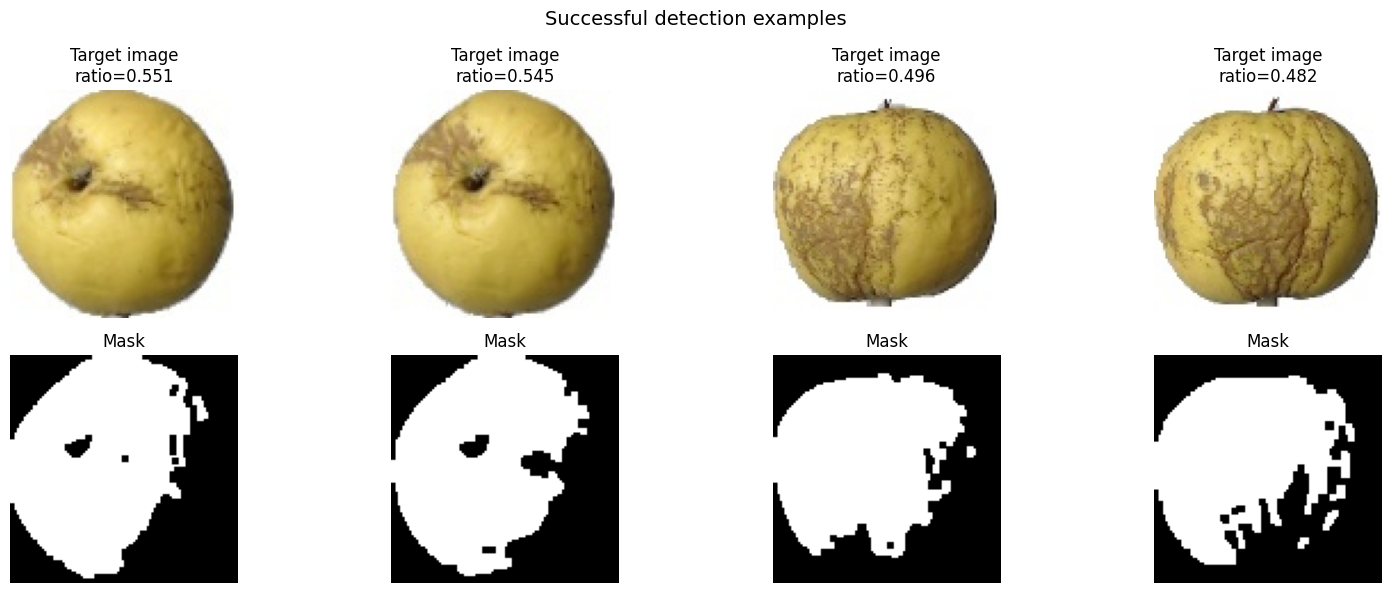

In [36]:
def plot_success_examples(num_examples=4):
    examples = []

    # collect true positives
    for images, labels in test_loader:
        for img_tensor, label in zip(images, labels):
            img_bgr = tensor_to_bgr(img_tensor)
            pred_target, ratio = is_target_image_with_thresh(
                img_bgr, lower_hsv, upper_hsv, best_thresh
            )
            true_target = (label.item() == target_idx)

            if pred_target and true_target:
                mask = color_track_mask(img_bgr, lower_hsv, upper_hsv)
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                examples.append((img_rgb, mask, ratio))

                if len(examples) >= num_examples:
                    break
        if len(examples) >= num_examples:
            break

    if len(examples) == 0:
        print("No true positive examples found in the test set.")
        return

    cols = num_examples
    plt.figure(figsize=(4 * cols, 6))

    for i, (img_rgb, mask, ratio) in enumerate(examples):
        # original image
        plt.subplot(2, cols, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Target image\nratio={ratio:.3f}")
        plt.axis("off")

        # mask
        plt.subplot(2, cols, cols + i + 1)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

    plt.suptitle("Successful detection examples", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_success_examples(num_examples=4)

#### Evaluation Plot - False positives

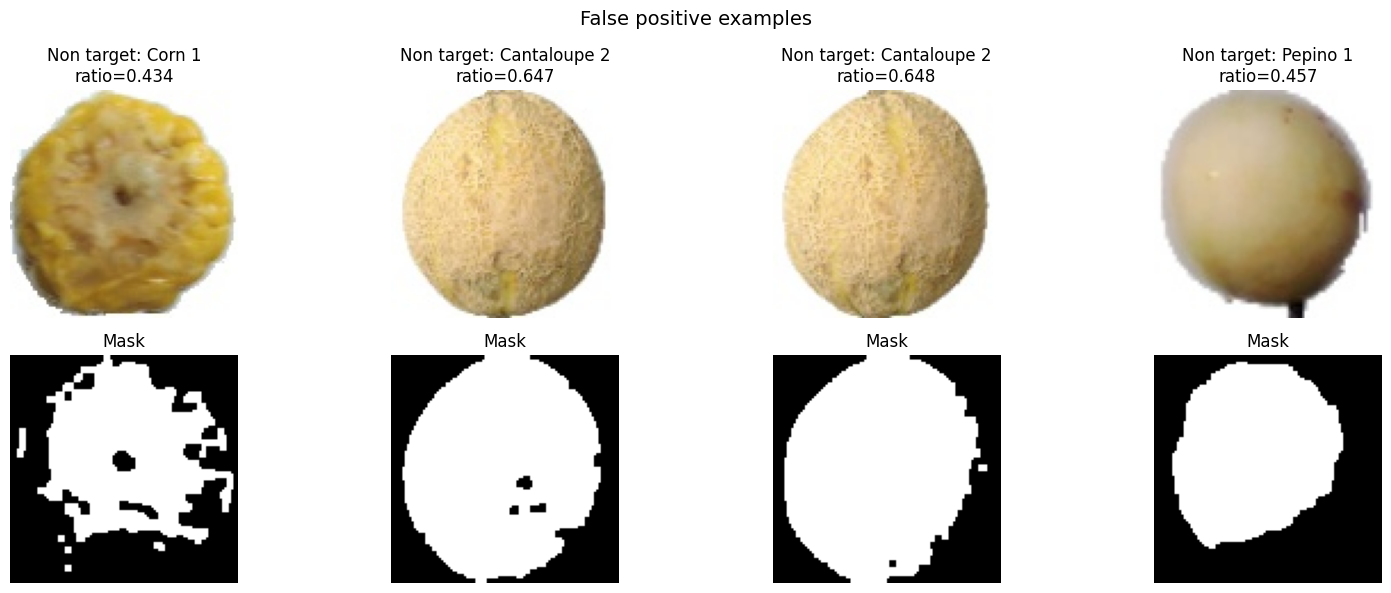

In [37]:
def plot_false_positive_examples(num_examples=4):
    examples = []

    # collect false positives
    for images, labels in test_loader:
        for img_tensor, label in zip(images, labels):
            img_bgr = tensor_to_bgr(img_tensor)
            pred_target, ratio = is_target_image_with_thresh(
                img_bgr, lower_hsv, upper_hsv, best_thresh
            )
            true_target = (label.item() == target_idx)

            if pred_target and not true_target:
                mask = color_track_mask(img_bgr, lower_hsv, upper_hsv)
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                class_name = class_names[label.item()]
                examples.append((img_rgb, mask, ratio, class_name))

                if len(examples) >= num_examples:
                    break
        if len(examples) >= num_examples:
            break

    if len(examples) == 0:
        print("No false positive examples found in the test set.")
        return

    cols = num_examples
    plt.figure(figsize=(4 * cols, 6))

    for i, (img_rgb, mask, ratio, class_name) in enumerate(examples):
        # original image
        plt.subplot(2, cols, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Non target: {class_name}\nratio={ratio:.3f}")
        plt.axis("off")

        # mask
        plt.subplot(2, cols, cols + i + 1)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

    plt.suptitle("False positive examples", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_false_positive_examples(num_examples=4)